In [19]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

# Plot for the rising bubble experiment
Initial conditions, and comparisons with blended solutions. Anything non-ensemble related is here.

## Comparison plots for psinc, imbalance and blended probe measurements 

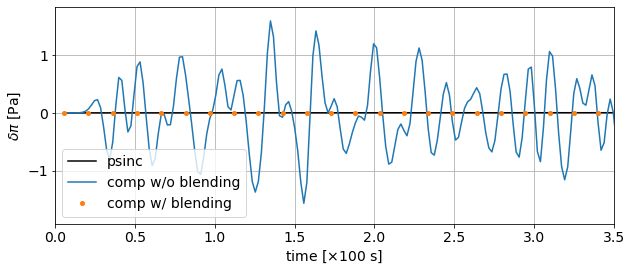

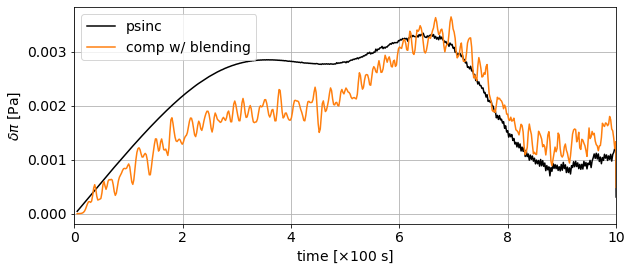

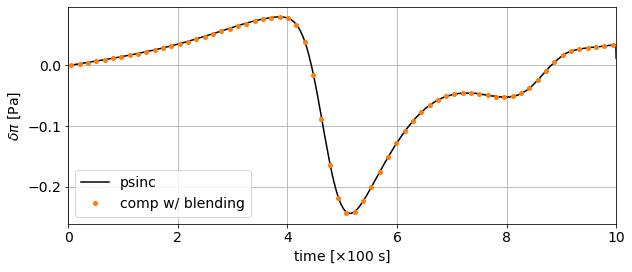

In [22]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']
# attributes = ['p2_half']

base_fn = "output_rising_bubble"
directory = "output_rising_bubble"

py_directory = "../../%s/" %directory

et = 10.0
N = 1
Nx, Ny = 160, 80
tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
times = np.arange(0,527)[1:]

probe_loc = [19,39]
l_typ = 'WINDOW_STEP'

rhoY = False
CFL = False

attr_labels = pt.labels_increment()

def ic_loader(tc,sfx1, swe):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    if swe:
        p_ref = ud.d_ref
    else:
        p_ref = ud.p_ref
    Msq = ud.Msq
    return p_ref, Msq

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=False)
    tt = tc.t_arr
    ens = ens[1:]
    tt = tt[1:]
    p_ref, Msq = ic_loader(tc,sfx,False)
          
    probe = ens[:,probe_loc[0],probe_loc[1]]
    probe *= p_ref * Msq
    probe = probe[1:] - probe[:-1]
    
    label = sfx + '_' + attribute
    return label, probe, tt

pls = []
ss = 'idt=2'

for i,attribute in enumerate(attributes):
    diff = True if attribute == 'p2_nodes' or attribute == 'p2_half' else False

    sfx1 = 'psinc_noib'
    if CFL : sfx1 = 'psinc_noib_CFLfixed'
    attribute1 = 'p2_nodes'
    if rhoY : attribute1 = 'rhoY'
    l1, p1, tt = get_ens(sfx1, diff, attribute1)
    l1 = 'psinc'
    
    sfx2 = 'comp_imbal_noib'
    if CFL : sfx2 = 'comp_imbal_noib_CFLfixed'
    attribute2 = 'p2_nodes'
    if rhoY : attribute2 = 'rhoY'
    l2_attr = np.copy(attribute2)
    l2, p2, tt = get_ens(sfx2, diff, attribute2)
    l2 = 'comp w/o blending'
    
    sfx3 = 'comp_imbal_half_ib-0'
    if CFL : sfx3 = 'comp_imbal_CFLfixed_ib-0'
    attribute3 = 'p2_nodes'
    if rhoY : attribute3 = 'rhoY'
    l3, p3, tt = get_ens(sfx3, diff, attribute3)
    l3 = 'comp w/ blending'

    ########################################
    #
    ########################################

    fs = (9,4) # used in the publication
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    if diff == True:
        tt = tt[1:]
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p2, 'C0', label=l2)
    ax.plot(tt, p3, 'C1o', ms=4, markevery=8, label=l3)
    
    ax.set_ylabel(r'$\delta \pi$ [Pa]')
    ax.set_xlabel(r'time [$\times 100$ s]')
    ax.set_xlim([0.0,3.5])
    ax.grid()
    ax.legend()
    
    pl.img.tight_layout()
    
    fn = 'rb_%i_%i_w_imbal' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    
    ########################################
    #
    ########################################
    
    _, p1, _ = get_ens(sfx1, diff, attribute1)
    _, p2, _ = get_ens(sfx2, diff, attribute2)
    _, p3, _ = get_ens(sfx3, diff, attribute3)

    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p3, 'C1', ms=4, markevery=8, label=l3)

    
    ax.set_ylabel(r'$\delta \pi$ [Pa]')
    ax.set_xlabel(r'time [$\times 100$ s]')
    ax.set_xlim([0.0,10.0])
    ax.grid()
    ax.legend()
    
    pl.img.tight_layout()
    
    
    fn = 'rb_%i_%i_w_ib' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    
    ########################################
    #
    ########################################
    
    probe_loc = [79,39]
    _, p1, _ = get_ens(sfx1, diff, attribute1)
    _, p2, _ = get_ens(sfx2, diff, attribute2)
    _, p3, _ = get_ens(sfx3, diff, attribute3)

    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p3, 'C1o', ms=4, markevery=8, label=l3)
    
    ax.set_ylabel(r'$\delta \pi$ [Pa]')
    ax.set_xlabel(r'time [$\times 100$ s]')
    ax.set_xlim([0.0,10.0])
    ax.grid()
    ax.legend()
    
    pl.img.tight_layout()
    
    fn = 'rb_%i_%i_w_ib' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)

## Contour plot of the pressure perturbation

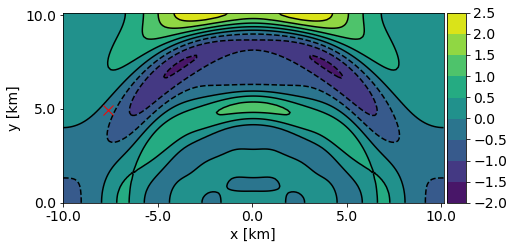

In [25]:
attribute = 'p2_nodes'
et = 10.0
N = 1

base_fn = "output_rising_bubble"
directory = "output_rising_bubble"
py_directory = "../../%s/" %directory

Nx, Ny = 160, 80
euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
tags = euler_tc.get_tag_dict()

times = [14,15]
l_typ = 'WINDOW_STEP'
        
prt = utils.prt_time(debug=False)
attr_labels = pt.labels_increment()

def ic_loader(tc,sfx1, swe):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    if swe:
        p_ref = ud.d_ref
    else:
        p_ref = ud.p_ref
    Msq = ud.Msq
    return p_ref, Msq

def get_ens(tc, sfx , diff, attribute, swe=False):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tags[9])[1]
    p_ref, Msq = ic_loader(tc,sfx,swe)
    ens = ens.T * p_ref * Msq

    label = sfx + '_' + attribute
    return label, ens

diff = True
sfx1 = 'debug_rkadv_comp_noib'
sfx1 = 'comp_imbal_noib'
attribute = 'rhoY'
l1, a1 = get_ens(euler_tc, sfx1, diff, attribute)
attribute = 'p2_nodes'
l2, a2 = get_ens(euler_tc, sfx1, diff, attribute)

# pl_lst = [[a1/a2 * 300.0, '']]
pl_lst = [[a2, '']]

pl = pt.plotter(pl_lst,ncols=2,figsize=(9,4),sharey=False)
x_axs = [-10.0,-5.0,0.0,5.0,10.0]
y_axs = [0.0,5.0,10.0]
x_loc = np.linspace(0,Nx-1,5)
y_loc = np.linspace(0,Ny-1,3)
x_label = r'x [km]'
y_label = r'y [km]'
marker = (19,39)

pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label,marker=marker)
_ = pl.plot(aspect='equal',method='contour')
pl.save_fig('./output/rb_deltap_contour')

## Comparison of balanced and non-balanced probe measurements for CFL-constrained case

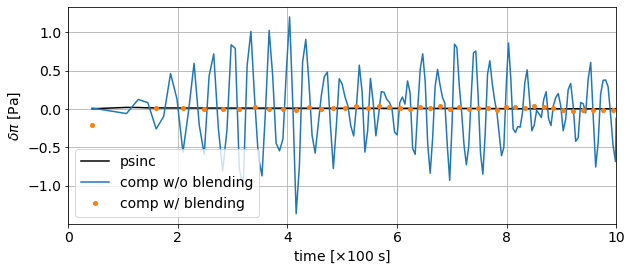

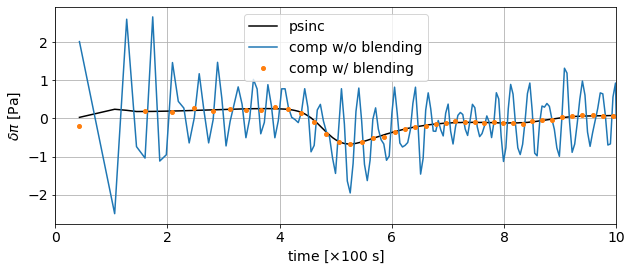

In [28]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']
# attributes = ['p2_half']

base_fn = "output_rising_bubble"
directory = "output_rising_bubble"

py_directory = "../../%s/" %directory

et = 10.0
N = 1
Nx, Ny = 160, 80
tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

p_ref = 8.61 * 1e4
# times = np.arange(0,527)[1:]#[:186]
times = np.arange(0,164)#[:19]

probe_loc = [19,39]
# probe_loc = [79,39]
l_typ = 'WINDOW_STEP'

rhoY = False
CFL = True

attr_labels = pt.labels_increment()

def ic_loader(tc,sfx1, swe):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    if swe:
        p_ref = ud.d_ref
    else:
        p_ref = ud.p_ref
    Msq = ud.Msq
    return p_ref, Msq

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=False)
    tt = tc.t_arr
    ens = ens[1:]
    tt = tt[1:]
    
    p_ref, Msq = ic_loader(tc,sfx,False)
    probe = ens[:,probe_loc[0],probe_loc[1]]
    probe *= p_ref * Msq
    probe = probe[1:] - probe[:-1]
    
    label = sfx + '_' + attribute
    return label, probe, tt

pls = []
ss = 'idt=2'

for i,attribute in enumerate(attributes):
    diff = True if attribute == 'p2_nodes' or attribute == 'p2_half' else False

    sfx1 = 'psinc_noib'
    if CFL : sfx1 = 'psinc_noib_CFLfixed'
    attribute1 = 'p2_nodes'
    if rhoY : attribute1 = 'rhoY'
    l1, p1, tt = get_ens(sfx1, diff, attribute1)
    l1 = 'psinc'
    
    sfx2 = 'comp_imbal_noib'
    if CFL : sfx2 = 'comp_imbal_noib_CFLfixed'
    attribute2 = 'p2_nodes'
    if rhoY : attribute2 = 'rhoY'
    l2_attr = np.copy(attribute2)
    l2, p2, tt = get_ens(sfx2, diff, attribute2)
    l2 = 'comp w/o blending'
    
    sfx3 = 'comp_imbal_half_ib-0'
    if CFL : sfx3 = 'comp_imbal_half_CFLfixed_ib-0'
    attribute3 = 'p2_nodes'
    if rhoY : attribute3 = 'rhoY'
    l3, p3, tt = get_ens(sfx3, diff, attribute3)
    l3 = 'comp w/ blending'

    fs = (9,4) # used in the publication
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    if diff == True:
        tt = tt[1:]
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p2, 'C0', label=l2)
    ax.plot(tt, p3, 'C1o', ms=4, markevery=4, label=l3)
    
    fn = 'rb_slides'
    
    ax.set_ylabel(r'$\delta \pi$ [Pa]')
    ax.set_xlabel(r'time [$\times 100$ s]')
    ax.set_xlim([0.0,10.0])
    ax.grid()
    ax.legend()
    
    pl.img.tight_layout()
    
    fn = 'rb_cfl_%i_%i' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)
    
    
    ########################################
    #
    ########################################
    
    probe_loc = [79,39]
    _, p1, _ = get_ens(sfx1, diff, attribute1)
    _, p2, _ = get_ens(sfx2, diff, attribute2)
    _, p3, _ = get_ens(sfx3, diff, attribute3)
    
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)
    
    ax.plot(tt, p1, 'k', ms=4, label=l1)
    ax.plot(tt, p2, 'C0', label=l2)
    ax.plot(tt, p3, 'C1o', ms=4, markevery=4, label=l3)
    
    fn = 'rb_slides'
    
    ax.set_ylabel(r'$\delta \pi$ [Pa]')
    ax.set_xlabel(r'time [$\times 100$ s]')
    ax.set_xlim([0.0,10.0])
    ax.grid()
    ax.legend()
    
    pl.img.tight_layout()
    
    fn = 'rb_cfl_%i_%i' %(probe_loc[0],probe_loc[1])
    pl.save_fig('./output/%s' %fn)